# Cleaning ETH and RTH Market Data
We combine extended trading hours (ETH) and regular trading hours (RTH) datasets into tidy
assets and option dataframes ready for downstream analysis.

## Dataset Overview
- **RTH vs ETH**: RTH covers the standard 09:30–16:00 ET NYSE session while ETH captures overnight and
  pre/post-market activity. Comparing both windows is vital because volatility shocks can start or fade outside
  cash hours, yet still influence pricing when the market reopens.
- **SPX**: The S&P 500 index represents the underlying spot level for every SPX option we analyze; tracking it
  alongside option quotes lets us compute moneyness, spot returns, and link surface shifts to index swings.
- **VIX**: The CBOE Volatility Index summarizes the 30-day implied variance from listed options, so monitoring
  it provides a benchmark for whether our bespoke volatility surfaces are consistent with market sentiment.
- **ES futures**: Front-month E-mini S&P 500 futures trade nearly 24 hours, offering a tradable proxy for SPX
  during ETH. Their bid/ask levels reveal how much of a move occurs before the cash market opens and aid in
  aligning option timestamps with corresponding underlying prices.
- **SPX options**: These listed index options across strikes/expiries supply the bid/ask quotes feeding our
  implied-volatility surface, risk-neutral PDF extraction, and hedging analysis; clean quotes are essential for
  reliable Greeks and surface diagnostics.

## Imports and Paths

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from py_vollib.black_scholes import black_scholes as pyv_black_scholes
from py_vollib.black_scholes.implied_volatility import (
    implied_volatility as pyv_implied_volatility,
)

pd.options.display.width = 140
pd.options.display.max_columns = 20

PROJECT_ROOT = Path(".")
SESSION_FOLDERS = {"ETH": PROJECT_ROOT / "ETH", "RTH": PROJECT_ROOT / "RTH"}

## Helper Functions

In [2]:
# Helper routines: parsing CSVs, melting option quotes, and orchestrating session-level loads.
def parse_timestamped_csv(csv_path: Path) -> pd.DataFrame:
    """Load a CSV whose first column stores timestamps and return a tidy timestamp column."""
    frame = pd.read_csv(csv_path, index_col=0)
    frame.index = pd.to_datetime(frame.index)
    frame = frame.reset_index().rename(columns={"index": "timestamp"})
    return frame


def melt_option_quotes(frame: pd.DataFrame, value_name: str) -> pd.DataFrame:
    """Convert wide strike columns into long format for a single quote side."""
    melted = frame.melt(id_vars="timestamp", var_name="strike", value_name=value_name)
    melted["strike"] = pd.to_numeric(melted["strike"], errors="coerce")
    melted[value_name] = pd.to_numeric(melted[value_name], errors="coerce")
    return melted


def load_option_book(option_type: str) -> pd.DataFrame:
    """Load and merge bid/ask quotes for the requested option type across sessions."""
    records: list[pd.DataFrame] = []
    for session, folder in SESSION_FOLDERS.items():
        ask_files = sorted(folder.glob(f"*_{option_type}_ask_*.csv"))
        for ask_path in ask_files:
            stem_parts = ask_path.stem.split("_")
            quote_date = pd.to_datetime(stem_parts[0])
            expiry = pd.to_datetime(stem_parts[-1])
            bid_path = ask_path.with_name(ask_path.name.replace("_ask_", "_bid_"))

            ask_frame = melt_option_quotes(parse_timestamped_csv(ask_path), "ask")
            bid_frame = melt_option_quotes(parse_timestamped_csv(bid_path), "bid")
            merged = pd.merge(
                ask_frame, bid_frame, on=["timestamp", "strike"], how="outer"
            )

            merged["expiry"] = expiry
            merged["session"] = session
            merged["mid"] = merged[["bid", "ask"]].mean(axis=1)
            merged["time_to_maturity_days"] = (
                ((merged["expiry"] - merged["timestamp"]).dt.total_seconds() / 86400)
                .round()
                .astype("Int64")
            )

            records.append(merged)

    long_df = pd.concat(records, ignore_index=True)
    long_df = long_df.sort_values(["timestamp", "strike"]).reset_index(drop=True)
    return long_df


def load_assets() -> pd.DataFrame:
    """Load SPX/ES/VIX snapshots from both sessions."""
    frames: list[pd.DataFrame] = []
    for session, folder in SESSION_FOLDERS.items():
        for csv_path in sorted(folder.glob("*_assets.csv")):
            frame = parse_timestamped_csv(csv_path)
            frame["session"] = session
            frames.append(frame)

    assets = pd.concat(frames, ignore_index=True)
    assets = assets.astype(
        {
            "SPX": "Float64",
            "ES_BID": "Float64",
            "ES_ASK": "Float64",
            "VIX": "Float64",
            "session": "category",
        }
    )
    assets = assets.sort_values("timestamp").reset_index(drop=True)
    return assets

## Implied Volatility Smiles

In [3]:
def compute_implied_vol_smiles(
    option_df: pd.DataFrame,
    assets_df: pd.DataFrame,
    option_type: str,
    rate: float = 0.0,
    tolerance: str = "2min",
) -> pd.DataFrame:
    """Compute implied volatilities grouped by time-to-maturity and strike."""
    quotes = option_df.dropna(subset=["mid", "strike", "time_to_maturity_days"]).copy()
    quotes = quotes[(quotes["mid"] > 0) & (quotes["time_to_maturity_days"] > 0)]
    quotes["session"] = quotes["session"].astype(str)
    quotes = quotes.sort_values("timestamp")

    spot = assets_df[["timestamp", "session", "SPX"]].copy()
    spot["session"] = spot["session"].astype(str)
    spot = spot.sort_values("timestamp")

    merged = pd.merge_asof(
        quotes,
        spot,
        on="timestamp",
        by="session",
        direction="nearest",
        tolerance=pd.Timedelta(tolerance),
    ).dropna(subset=["SPX"])

    merged["time_to_maturity_years"] = merged["time_to_maturity_days"] / 365.0

    merged["implied_vol"] = merged.apply(
        lambda row: implied_volatility(
            option_type=option_type,
            spot=row["SPX"],
            strike=row["strike"],
            rate=rate,
            market_price=row["mid"],
            time_to_maturity=row["time_to_maturity_years"],
        ),
        axis=1,
    )

    merged["implied_vol"] = merged["implied_vol"].replace([np.inf, -np.inf], np.nan)
    merged = merged.dropna(subset=["implied_vol"])
smiles = (
        merged.groupby(["time_to_maturity_days", "strike"])["implied_vol"]
        .median()
        .reset_index()
    )
    smiles["option_type"] = option_type
    return smiles


def plot_implied_vol_smiles(smiles: pd.DataFrame, title: str) -> None:
    """Plot all smiles on a single chart, colored by time to maturity."""
    if smiles.empty:
        raise ValueError("No implied volatility data available for plotting.")

    plt.figure(figsize=(10, 6))
    for maturity, group in smiles.groupby("time_to_maturity_days"):
        sorted_group = group.sort_values("strike")
        plt.plot(
            sorted_group["strike"],
            sorted_group["implied_vol"],
            label=f"{int(maturity)}d",
        )

    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(title="Time to Maturity (days)")
    plt.tight_layout()

IndentationError: unexpected indent (1069752334.py, line 48)

## Visualization Utilities

In [4]:
# Provide reusable plotting helpers for exploratory analysis.
SESSION_COLORS = {"RTH": "#2ca02c", "ETH": "#1f77b4"}


def _shade_session_blocks(ax, series: pd.DataFrame) -> None:
    """Overlay lightly shaded regions for ETH and RTH stretches."""
    legend_labels = set()
    session_switch = series["session"].ne(series["session"].shift()).cumsum()
    for _, block in series.groupby(session_switch):
        session_name = block["session"].iloc[0]
        color = SESSION_COLORS.get(session_name, "gray")
        ax.axvspan(
            block["timestamp"].iloc[0],
            block["timestamp"].iloc[-1],
            color=color,
            alpha=0.08,
            label=session_name if session_name not in legend_labels else None,
        )
        legend_labels.add(session_name)


def _shade_weekends(ax, series: pd.DataFrame) -> None:
    """Shade weekend periods to highlight market closures."""
    if series.empty:
        return
    start = series["timestamp"].min().normalize()
    end = series["timestamp"].max().normalize()
    dates = pd.date_range(start, end, freq="D")
    weekend_label_added = False
    for day in dates:
        if day.dayofweek == 5:  # Saturday marks the start of the weekend
            ax.axvspan(
                day,
                day + pd.Timedelta(days=2),
                color="gray",
                alpha=0.12,
                label="Weekend" if not weekend_label_added else None,
            )
            weekend_label_added = True


def plot_timeseries(
    data: pd.DataFrame,
    column: str,
    label: str,
    session: str | None = None,
    line_color: str = "black",
) -> None:
    """Display a single time series with ETH/RTH overlays and weekend cues."""
    subset = data.copy()
    if session is not None:
        subset = subset[subset["session"] == session]

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(
        subset["timestamp"],
        subset[column],
        color=line_color,
        linewidth=1.5,
        label=label,
    )

    _shade_session_blocks(ax, subset)
    _shade_weekends(ax, subset)

    ax.set_ylabel(label)
    ax.set_xlabel("Timestamp")
    ax.set_title(f"{label} Over Time" + (f" - {session}" if session else ""))
    ax.grid(True, linestyle="--", alpha=0.3)
    event_date = pd.Timestamp("2025-04-02 16:00:00")
    ax.axvline(
        event_date,
        color="red",
        linestyle=":",
        linewidth=2,
        label="Liberation Day Tariffs (2 Apr 2025)",
    )
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc="best")
    fig.autofmt_xdate()
    plt.tight_layout()

## Load Assets Across Sessions

In [5]:
# Load, clean, and combine SPX, ES, and VIX snapshots from ETH and RTH.
assets_df = load_assets()
assets_df.head()

/var/folders/p3/7gy013yx2hn3mns87ysh4z4w0000gn/T/ipykernel_16700/1768768629.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  assets = pd.concat(frames, ignore_index=True)


,timestamp,SPX,ES_BID,ES_ASK,VIX,session
0,2025-04-01 09:31:21.491248,5590.32,5631.75,5632.0,22.66,RTH
1,2025-04-01 09:31:24.535800,5590.7,5631.75,5632.0,22.66,RTH
2,2025-04-01 09:31:27.582698,5589.06,5629.5,5629.75,22.66,RTH
3,2025-04-01 09:31:30.632772,5588.66,5630.5,5630.75,22.66,RTH
4,2025-04-01 09:31:33.638817,5588.82,5629.75,5630.0,22.69,RTH


In [6]:
assets_df.dtypes

timestamp    datetime64[ns]
SPX                 Float64
ES_BID              Float64
ES_ASK              Float64
VIX                 Float64
session            category
dtype: object

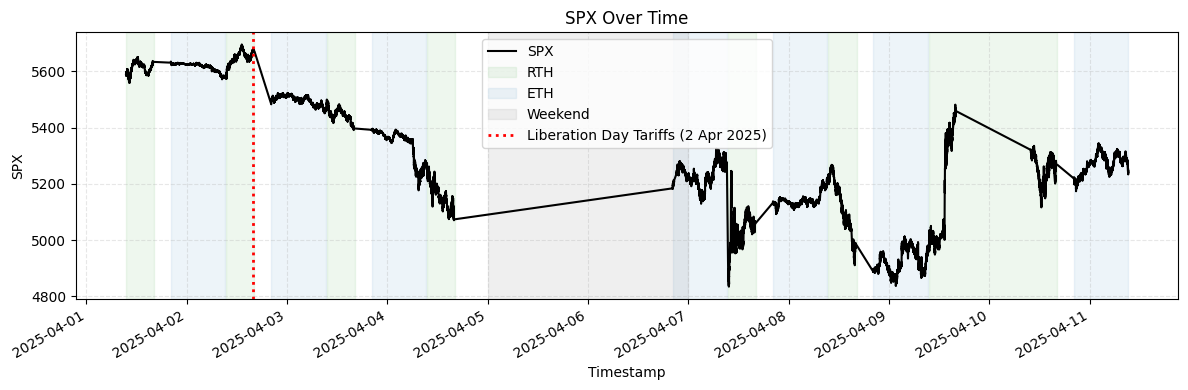

In [7]:
# Visualize SPX over time.
plot_timeseries(assets_df, column="SPX", label="SPX")

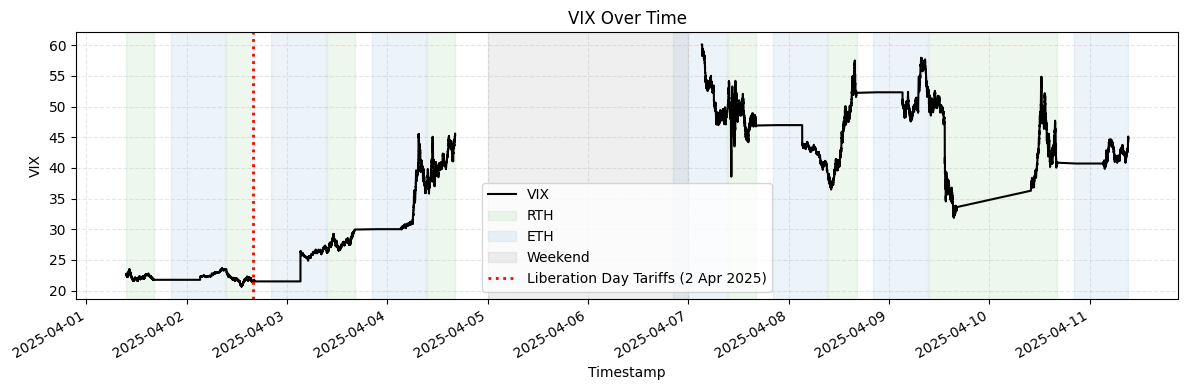

In [8]:
# Visualize VIX over time.
plot_timeseries(assets_df, column="VIX", label="VIX")

## Load Call Option Quotes

In [9]:
# Build the consolidated call option dataframe with bid/ask/mid quotes.
call_options_df = load_option_book("call")
call_options_df.head()

,timestamp,strike,ask,bid,expiry,session,mid,time_to_maturity_days
0,2025-04-01 09:31:21.491248,4600.0,1006.3,995.2,2025-04-16,RTH,1000.75,15
1,2025-04-01 09:31:21.491248,4625.0,981.5,971.7,2025-04-16,RTH,976.60,15
2,2025-04-01 09:31:21.491248,4650.0,956.7,945.7,2025-04-16,RTH,951.20,15
3,2025-04-01 09:31:21.491248,4675.0,932.0,921.4,2025-04-16,RTH,926.70,15
4,2025-04-01 09:31:21.491248,4700.0,907.2,896.6,2025-04-16,RTH,901.90,15


In [10]:
quotes = call_options_df.dropna(subset=["mid", "strike", "time_to_maturity_days"]).copy()
quotes = quotes[(quotes["mid"] > 0) & (quotes["time_to_maturity_days"] > 0)]
quotes["session"] = quotes["session"].astype(str)
quotes = quotes.sort_values("timestamp")

spot = assets_df[["timestamp", "session", "SPX"]].copy()
spot["session"] = spot["session"].astype(str)
spot = spot.sort_values("timestamp")

tolerance="2min"

merged = pd.merge_asof(
    quotes,
    spot,
    on="timestamp",
    by="session",
    direction="nearest",
    tolerance=pd.Timedelta(tolerance),
).dropna(subset=["SPX"])

merged["time_to_maturity_years"] = merged["time_to_maturity_days"] / 365.0
merged

,timestamp,strike,ask,bid,expiry,session,mid,time_to_maturity_days,SPX,time_to_maturity_years
0,2025-04-01 09:31:21.491248,4600.0,1006.30,995.2,2025-04-16,RTH,1000.750,15,5590.32,0.041096
1,2025-04-01 09:31:21.491248,5850.0,9.90,9.2,2025-04-16,RTH,9.550,15,5590.32,0.041096
2,2025-04-01 09:31:21.491248,5825.0,13.60,12.8,2025-04-16,RTH,13.200,15,5590.32,0.041096
3,2025-04-01 09:31:21.491248,5800.0,18.20,17.4,2025-04-16,RTH,17.800,15,5590.32,0.041096
4,2025-04-01 09:31:21.491248,5775.0,24.00,23.1,2025-04-16,RTH,23.550,15,5590.32,0.041096
...,...,...,...,...,...,...,...,...,...,...
12464850,2025-04-11 09:14:58.970700,5175.0,289.60,285.8,2025-05-15,ETH,287.700,34,5242.55,0.093151
12464851,2025-04-11 09:14:58.970700,5150.0,306.40,302.6,2025-05-15,ETH,304.500,34,5242.55,0.093151
12464852,2025-04-11 09:14:58.970700,5125.0,323.60,319.8,2025-05-15,ETH,321.700,34,5242.55,0.093151
12464853,2025-04-11 09:14:58.970700,5050.0,376.50,372.9,2025-05-15,ETH,374.700,34,5242.55,0.093151


In [11]:
pyv_implied_volatility(1000.750, 5590.32, 4600, 0.041096, 0.02, "c")

0.5208914423908315

In [13]:
def safe_iv(row):
    try:
        return pyv_implied_volatility(
            price=row["mid"],
            S=row["SPX"],
            K=row["strike"],
            r=0.02,
            flag=row["call"],
            t=row["time_to_maturity_years"],
        )
    except Exception as e:
        print("Bad row:", row.name, e)
        print(row[["mid", "SPX", "strike", "time_to_maturity_years"]])
        return np.nan

merged["implied_vol"] = merged.apply(safe_iv, axis=1)
merged["implied_vol"] = merged.apply(
    lambda row: save_iv(row),
    axis=1,
)
merged

Bad row: 0 'price'


KeyError: "None of [Index(['price', 'S', 'K', 't', 'flag'], dtype='object')] are in the [index]"

### Call Implied Volatility Smiles

In [ ]:
# Compute per-maturity call smiles (py_vollib implied vols) and plot them.
call_smiles = compute_implied_vol_smiles(call_options_df, assets_df, option_type="call")
plot_implied_vol_smiles(call_smiles, title="SPX Call Implied Volatility Smiles")

## Load Put Option Quotes

In [ ]:
# Build the consolidated put option dataframe with bid/ask/mid quotes.
put_options_df = load_option_book("put")
put_options_df.head()

### Put Implied Volatility Smiles

In [ ]:
# Compute per-maturity put smiles (py_vollib implied vols) and plot them.
put_smiles = compute_implied_vol_smiles(put_options_df, assets_df, option_type="put")
plot_implied_vol_smiles(put_smiles, title="SPX Put Implied Volatility Smiles")